# dataload, EDA and baseline

In [1]:
#imports

# data processing
import numpy as np 
import pandas as pd 
import random
import collections
from collections import defaultdict

# visualization 
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import * 

sns.set_style("whitegrid")

# files operations
import os
from pathlib import Path
from os import listdir
from os.path import isfile, join
from PIL import Image
from shutil import copy
from shutil import copyfile
from shutil import copytree, rmtree

# modelling
import sklearn
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

# deep learning
import tensorflow
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image as keras_image
from tensorflow.keras.utils import load_img, img_to_array

/Users/krystiank/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#setting data source
ld = os.listdir("garbage_classification/")
ld.pop(0)
path = "garbage_classification/"

In [3]:
#class imbalance - depending on models performance it could be addressed by multiplication and modification of underrepresented class or downsampling
for category in ld:
    count_category = 0
    for photo in os.listdir(path + category):
        count_category += 1
    print(str(category) + " has " + str(count_category) + " photos")  

green-glass has 629 photos
white-glass has 775 photos
brown-glass has 607 photos
plastic has 865 photos


In [4]:
#data load
img_array=[]
class_name=[]
img_name=[]

def create_image_df(img_folder): # path_resized_baseline_train
   
    for img_class_subfolder in os.listdir(img_folder):
        if img_class_subfolder == '.DS_Store':
            continue
        for file in os.listdir(os.path.join(img_folder, img_class_subfolder)):
       
            image_path= os.path.join(img_folder, img_class_subfolder,  file)
            
            img = tensorflow.keras.utils.load_img(image_path, target_size=(71, 71),color_mode = "rgb") #changed from 128x128
            x = tensorflow.keras.utils.img_to_array(img)
            x = x/255
            x = np.expand_dims(x, axis=0)
            x = np.transpose(x.flatten())
            
            # append to list
            img_array.append(x)
            class_name.append(img_class_subfolder)
            img_name.append(file)
    
    # create df and concatenate 3 elements
    df_img_array = pd.DataFrame(data = img_array)
    df_name = pd.DataFrame({'img_id':img_name})    
    df_class = pd.DataFrame({'class_name':class_name})
            
    # merge dataframes
    img_df_temp = df_img_array.merge(df_name, left_index=True, right_index=True)
    img_df = img_df_temp.merge(df_class, left_index=True, right_index=True)
               
    return img_df

In [5]:
df = create_image_df(path+'/')

In [6]:
# reordering columns
cols_to_order = ['img_id', 'class_name']
new_columns = cols_to_order + (df.columns.drop(cols_to_order).tolist())
image_df = df[new_columns]
image_df.head()

,img_id,class_name,0,1,2,3,4,5,6,7,...,15113,15114,15115,15116,15117,15118,15119,15120,15121,15122
0,green-glass221.jpg,green-glass,0.486275,0.505882,0.490196,0.490196,0.509804,0.494118,0.494118,0.513726,...,0.509804,0.552941,0.537255,0.501961,0.552941,0.537255,0.501961,0.549020,0.533333,0.498039
1,green-glass547.jpg,green-glass,0.827451,0.800000,0.768627,0.847059,0.819608,0.788235,0.858824,0.831373,...,0.890196,0.988235,0.960784,0.921569,0.968627,0.941176,0.901961,0.909804,0.870588,0.835294
2,green-glass553.jpg,green-glass,0.921569,0.921569,0.921569,0.937255,0.937255,0.937255,0.992157,0.992157,...,0.913725,0.996078,0.996078,0.996078,0.937255,0.937255,0.937255,0.933333,0.933333,0.933333
3,green-glass235.jpg,green-glass,0.909804,0.925490,0.972549,0.901961,0.917647,0.964706,0.901961,0.909804,...,0.925490,0.850980,0.862745,0.921569,0.862745,0.870588,0.921569,0.866667,0.874510,0.925490
4,green-glass209.jpg,green-glass,0.827451,0.752941,0.686275,0.831373,0.756863,0.690196,0.835294,0.760784,...,0.635294,0.800000,0.729412,0.635294,0.800000,0.729412,0.635294,0.815686,0.745098,0.650980


In [7]:
# pickle df
#image_df.to_pickle("image_df.pickle")

In [8]:
#defining features and target
features = image_df.iloc[:,2:]
target = image_df.iloc[:,1:2]

#train/val split 80%/20%
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=.20, random_state=42)

#defining labels
y_train_label = y_train.values.astype(object)
y_val_label = y_val.values.astype(object)

#encoding cathegorical labels into numerical
encoder = preprocessing.LabelEncoder()
encoder.fit(y_train_label.ravel())
y_train = encoder.transform(y_train_label.ravel())
encoder.fit(y_val_label.ravel())
y_val = encoder.transform(y_val_label.ravel())

#scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Logistic Regression Model for performance baseline

In [9]:
#Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space. The input data is centered but not scaled for each feature before applying the SVD.
pca = PCA(n_components=2)

X_train_2PC = pca.fit_transform(X_train_scaled)
X_val_2PC = pca.transform(X_val_scaled)

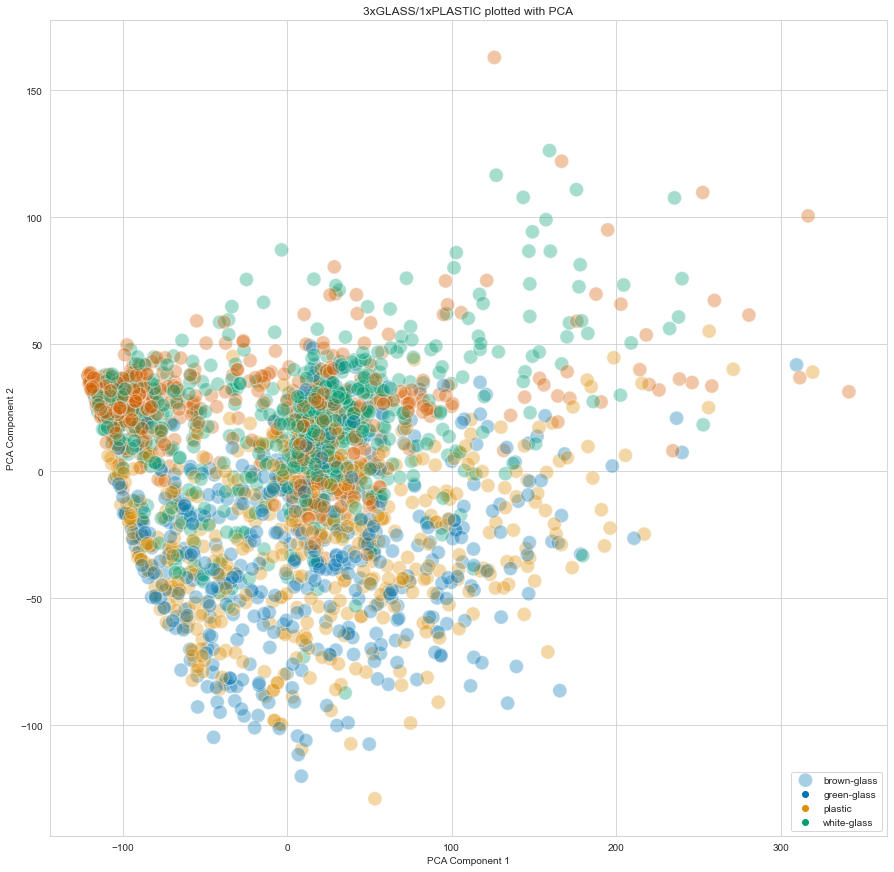

In [10]:
plt.figure(figsize=(15,15))
sns.set_style("whitegrid")
sns.scatterplot(x=X_train_2PC[:, 0], y=X_train_2PC[:, 1], 
                hue=y_train, alpha=.35,
                palette=sns.color_palette("colorblind", 4),
                s=200)
plt.legend(['brown-glass', 'green-glass', 'plastic', 'white-glass'], loc='lower right')
xlabel("PCA Component 1")
ylabel("PCA Component 2")
title("3xGLASS/1xPLASTIC plotted with PCA")
plt.savefig('PCA.jpg');

In [11]:
lr = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs')
lr.fit(X_train_2PC, y_train)

#prediction
y_pred_t = lr.predict(X_train_2PC)
y_pred = lr.predict(X_val_2PC)

#F1 and accuracy
f1_t = f1_score(y_train, y_pred_t, average = 'macro')
accuracy_t = accuracy_score(y_train, y_pred_t)
f1 = f1_score(y_val, y_pred, average = 'macro')
accuracy = accuracy_score(y_val, y_pred)

print(f'Logistic Regression | Training Accuracy: \t{accuracy_t} | Training F1 score: \t{f1_t} \n')
print(f'Logistic Regression | Validation Accuracy: \t{accuracy} | Validation F1 score: \t{f1} \n')

Logistic Regression | Training Accuracy: 	0.4930434782608696 | Training F1 score: 	0.47043650232996576 

Logistic Regression | Validation Accuracy: 	0.4739583333333333 | Validation F1 score: 	0.4593363134855781 



**Validation F1 score: 0.459**

In [12]:
#when used scaled data, with no PCA scores are similar to random forest but it starts to be demanding for cpu

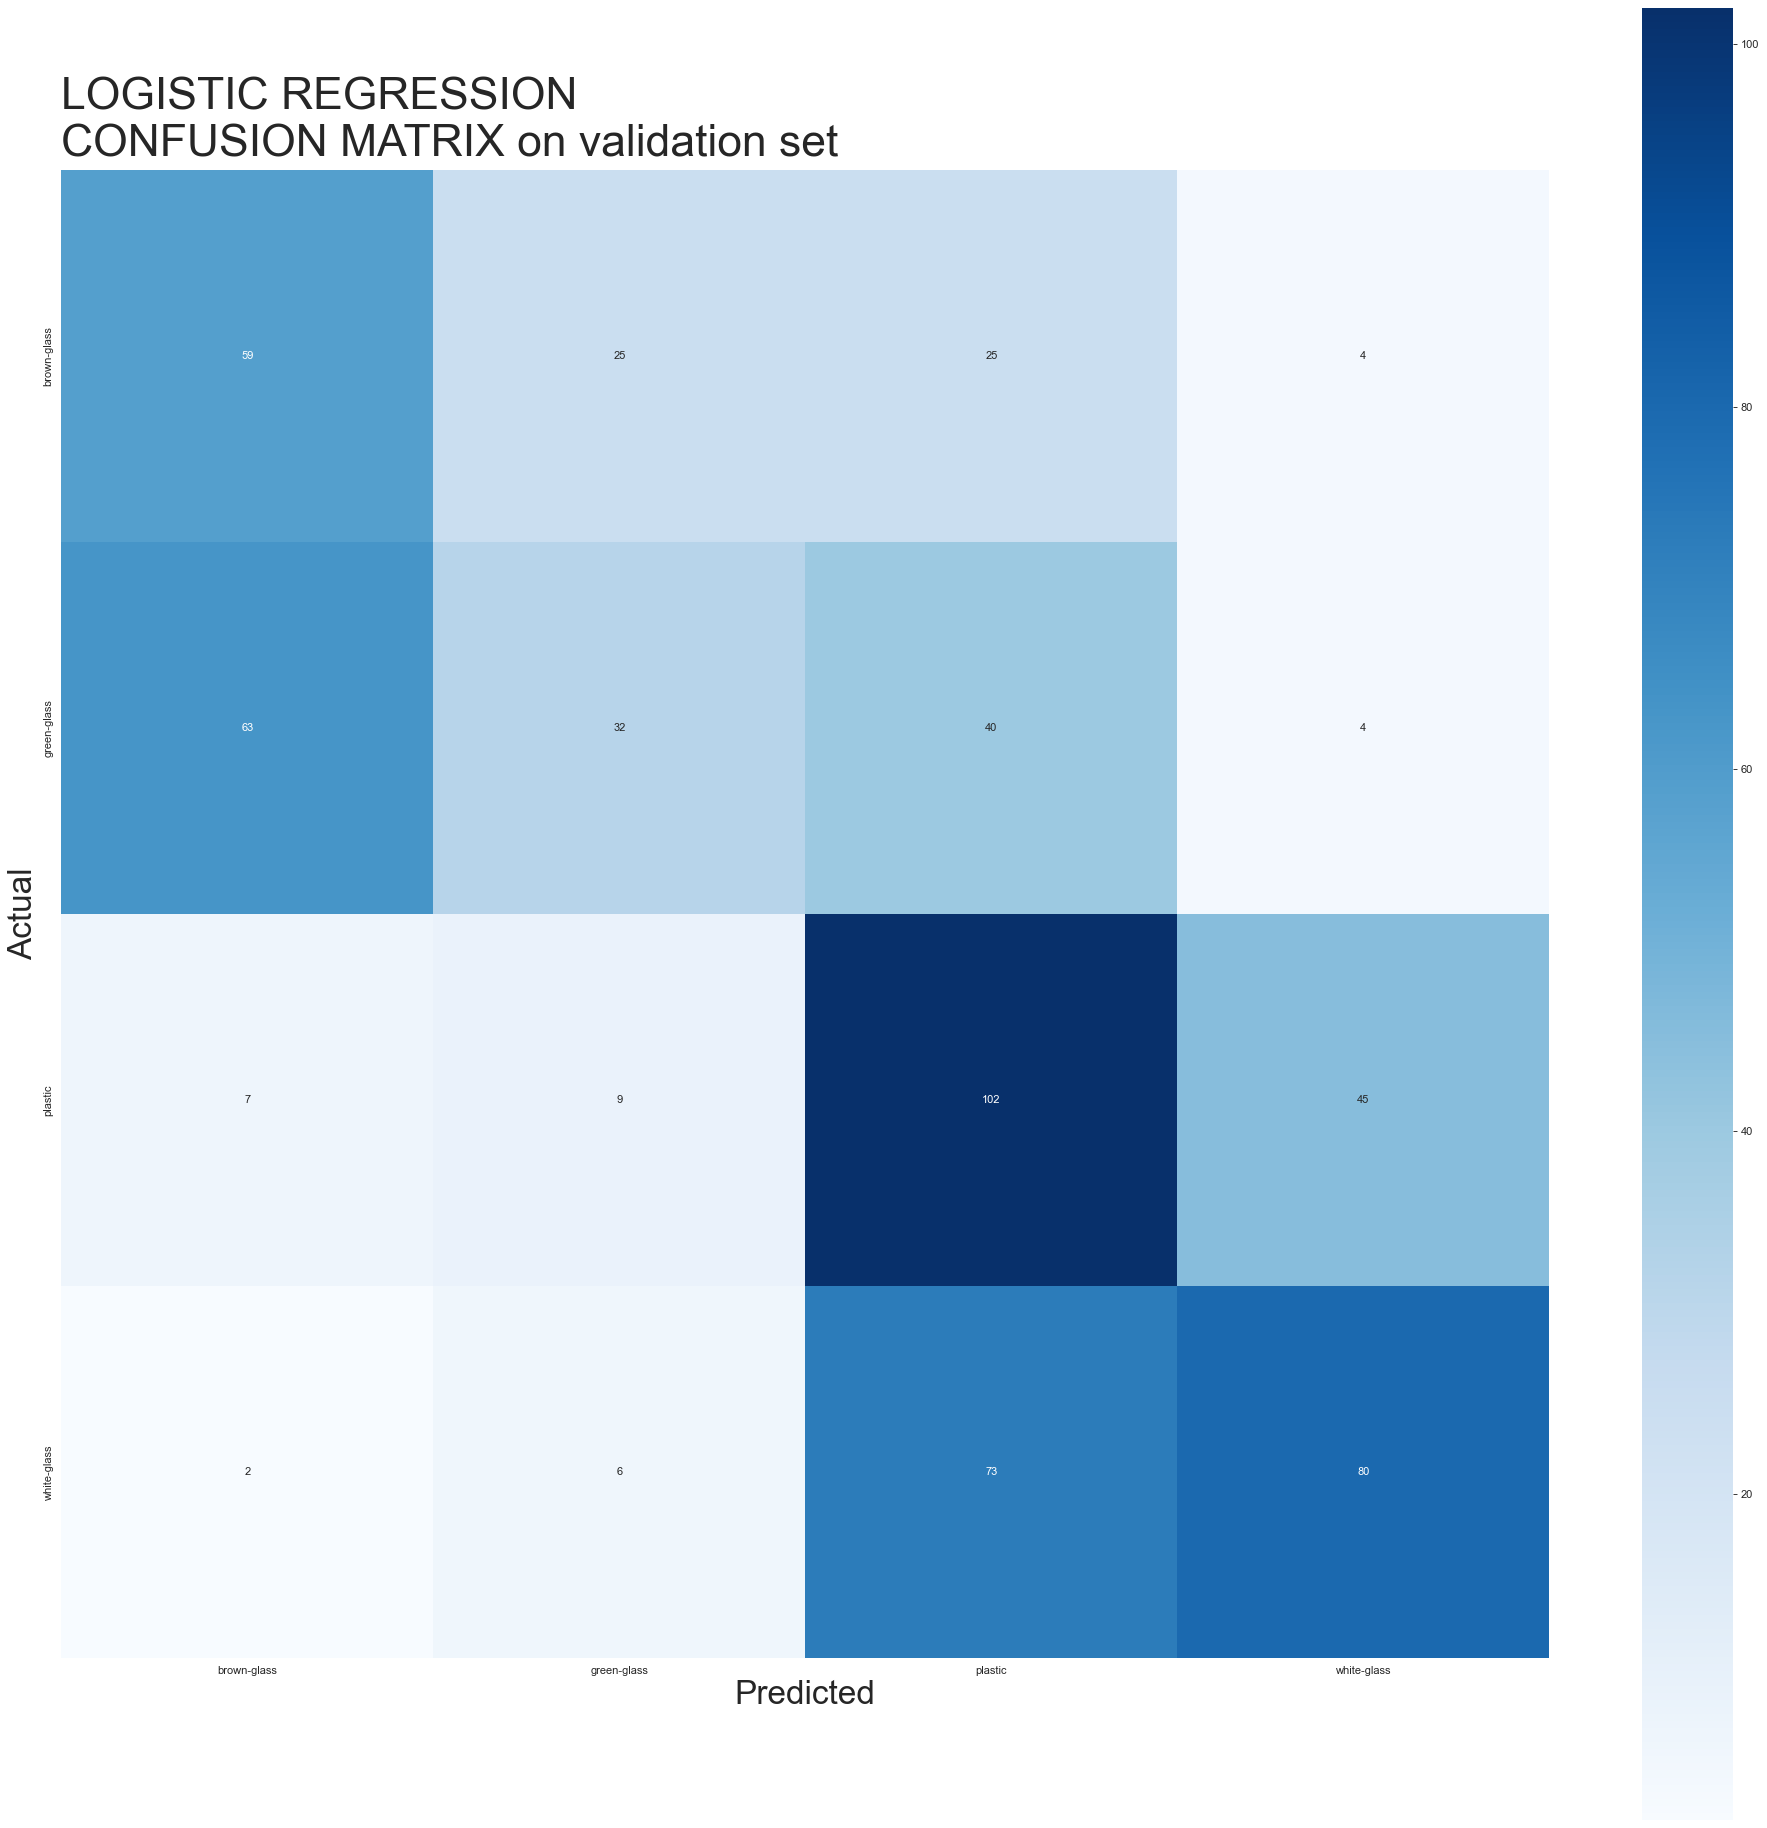

In [13]:
#Confusion Matrix
rf_confusion = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(30, 30), dpi=80)
ax = plt.subplot()
sns.heatmap(rf_confusion, cmap = "Blues", annot=True, square=True, fmt=".0f")
sns.set(font_scale=2.5)

plt.xlabel('Predicted',fontsize = 30)
plt.ylabel('Actual',fontsize = 30)
ax.xaxis.set_ticklabels(['brown-glass', 'green-glass', 'plastic', 'white-glass'])
ax.yaxis.set_ticklabels(['brown-glass', 'green-glass', 'plastic', 'white-glass'])
plt.title('LOGISTIC REGRESSION\nCONFUSION MATRIX on validation set', fontsize = 40, loc = 'left', pad = 12)
plt.savefig('CONFUSION_MATRIX.jpg');

verification

In [14]:
def show_and_test(image):
    i_pr = y_pred[image]
    i_va = y_val[image]
    i_li = ['brown-glass', 'green-glass', 'plastic', 'white-glass']
    print("Predicted: "+i_li[i_pr]+"   Actual: "+i_li[i_va])
    i_fi = image_df.iloc[X_val.iloc[image].name].img_id
    img = load_img('garbage_classification/'+i_li[i_va]+'/'+i_fi)
    return img

Predicted: plastic   Actual: plastic


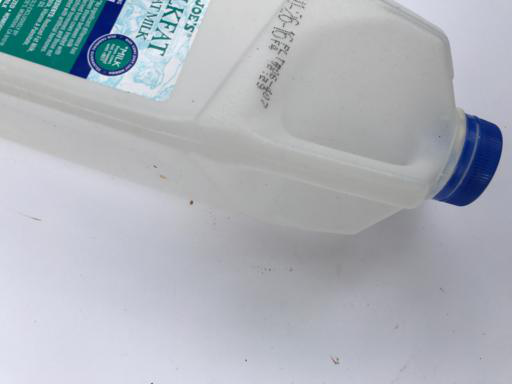

In [15]:
show_and_test(np.random.randint(0, len(y_pred)))

# Neural Network Model

In [16]:
# display and plotting imports
%pylab inline 
import seaborn as sns
sns.set()
from IPython.display import SVG

import pandas as pd

# sklearn imports
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans

# keras imports
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM

# gensim import for word2vec loading
from gensim.models.keyedvectors import KeyedVectors

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/krystiank/opt/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['fft', 'copy', 'random', 'power']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [17]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM
from keras import backend as K

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [18]:
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_train_cat

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [19]:
X_train_scaled.shape

(2300, 15123)

In [102]:

NN = Sequential()

NN.add(Dense(512,  input_dim = X_train_scaled.shape[1])) 
NN.add(Activation('relu'))
NN.add(Dropout(0.1))

NN.add(Dense(256))
NN.add(Activation('relu'))

NN.add(Dense(128, name = '2D_layer'))
NN.add(Activation('relu')) 

NN.add(Dense(4))
NN.add(Activation('softmax'))

NN.compile(loss='categorical_crossentropy',metrics=[f1_m])


run_hist = NN.fit(X_train_scaled, y_train_cat, validation_data = (X_val_scaled, y_val_cat), epochs=50, verbose=1,callbacks=[
        keras.callbacks.EarlyStopping(patience=8, verbose=1, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, verbose=1),
    ]) 


Epoch 1/50


2022-10-26 20:55:57.125333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - ETA: 0s - loss: 5.7201 - f1_m: 0.5088

2022-10-26 20:56:01.323978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - 5s 56ms/step - loss: 5.7201 - f1_m: 0.5088 - val_loss: 3.1684 - val_f1_m: 0.5389 - lr: 0.0010
Epoch 2/50
72/72 [==============================] - 3s 36ms/step - loss: 1.8657 - f1_m: 0.6005 - val_loss: 2.3194 - val_f1_m: 0.6071 - lr: 0.0010
Epoch 3/50
72/72 [==============================] - 3s 36ms/step - loss: 1.2687 - f1_m: 0.6528 - val_loss: 1.2129 - val_f1_m: 0.6786 - lr: 0.0010
Epoch 4/50
72/72 [==============================] - 3s 36ms/step - loss: 0.9181 - f1_m: 0.6922 - val_loss: 1.2425 - val_f1_m: 0.6104 - lr: 0.0010
Epoch 5/50
72/72 [==============================] - 3s 41ms/step - loss: 0.8531 - f1_m: 0.7060 - val_loss: 0.9417 - val_f1_m: 0.6851 - lr: 0.0010
Epoch 6/50
72/72 [==============================] - 3s 40ms/step - loss: 0.7184 - f1_m: 0.7347 - val_loss: 0.8527 - val_f1_m: 0.7249 - lr: 0.0010
Epoch 7/50
72/72 [==============================] - 3s 35ms/step - loss: 0.6999 - f1_m: 0.7426 - val_loss: 0.8279 - val_f1_m: 0.7041 - 

In [103]:
NN.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_105 (Dense)           (None, 512)               7743488   
                                                                 
 activation_115 (Activation)  (None, 512)              0         
                                                                 
 dropout_24 (Dropout)        (None, 512)               0         
                                                                 
 dense_106 (Dense)           (None, 256)               131328    
                                                                 
 activation_116 (Activation)  (None, 256)              0         
                                                                 
 2D_layer (Dense)            (None, 128)               32896     
                                                                 
 activation_117 (Activation)  (None, 128)            

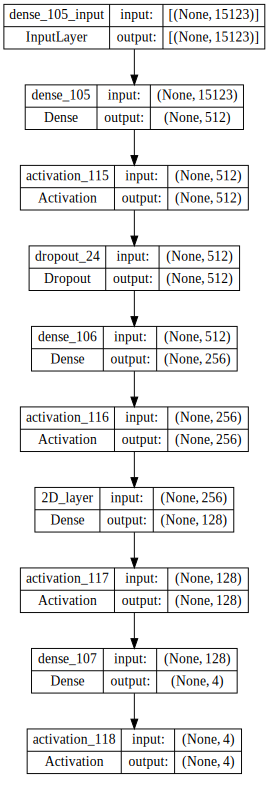

In [104]:
SVG(model_to_dot(NN, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

In [105]:
accuracy_score(y_val, np.argmax(NN.predict(X_val_scaled), axis=-1))

18/18 [==============================] - 0s 5ms/step


2022-10-26 20:56:50.419347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.7621527777777778

In [106]:
feature_extractor = \
    Model(inputs=NN.input, outputs=NN.get_layer('2D_layer').output) 

X_train_NN_features_2d = feature_extractor.predict(X_train_scaled)
X_test_NN_features_2d = feature_extractor.predict(X_val_scaled)

41/72 [================>.............] - ETA: 0s

2022-10-26 20:56:50.917684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 4ms/step


Text(0, 0.5, 'NN Feature 2')

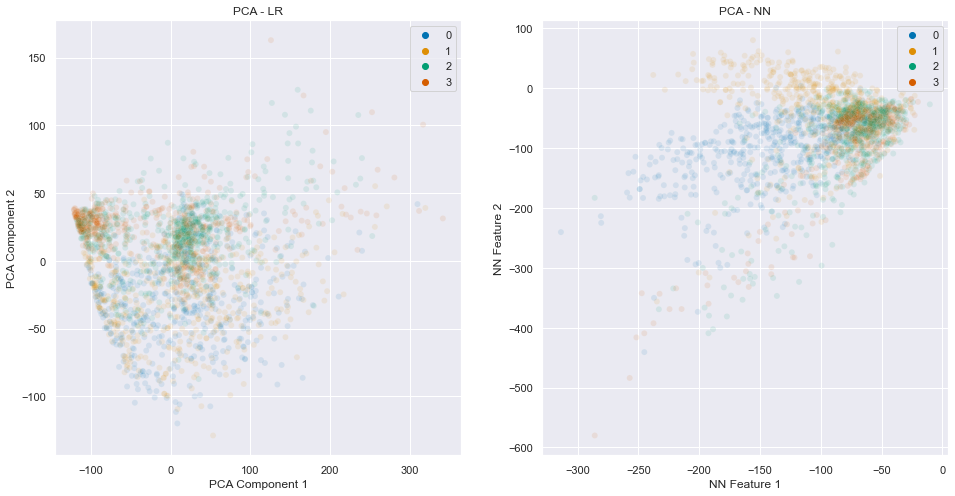

In [107]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

sns.scatterplot(
    x=X_train_2PC[:, 0],
    y=X_train_2PC[:, 1],
    hue=y_train,
    alpha=.1,
    palette=sns.color_palette("colorblind", 4),
    ax=axes[0],
)
axes[0].set_title("PCA - LR")
axes[0].set_xlabel("PCA Component 1")
axes[0].set_ylabel("PCA Component 2")


sns.scatterplot(
    x=X_train_NN_features_2d[:, 0],
    y=X_train_NN_features_2d[:, 1],
    hue=y_train,
    alpha=.1,
    palette=sns.color_palette("colorblind", 4),
    ax=axes[1],
)
axes[1].set_title("PCA - NN")
axes[1].set_xlabel("NN Feature 1")
axes[1].set_ylabel("NN Feature 2")

# CCN Model

In [108]:
from sklearn.datasets import fetch_openml
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [109]:
features = image_df.iloc[:,2:]
target = image_df.iloc[:,1:2]

In [110]:
features = features.values.reshape((-1,71,71,3)) 
features.shape

(2876, 71, 71, 3)

In [111]:
#train/val split 80%/20%
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=.20, random_state=42)

#encoding cathegorical labels into numerical
encoder = preprocessing.LabelEncoder()
encoder.fit(y_train_label.ravel())
y_train = encoder.transform(y_train_label.ravel())
encoder.fit(y_val_label.ravel())
y_val = encoder.transform(y_val_label.ravel())

y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)

X_train.shape

(2300, 71, 71, 3)

In [112]:
X_train.shape, y_train_cat.shape

((2300, 71, 71, 3), (2300, 4))

In [113]:
X_val.shape, y_val_cat.shape

((576, 71, 71, 3), (576, 4))

In [124]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, InputLayer

NN = Sequential()

NN.add(InputLayer(input_shape=X_train.shape[1:]))

# Conv block 1.  You can add more conv steps to
# each block to increase model capacity.
NN.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))
#NN.add(Conv2D(filters=16, kernel_size=3, activation='relu', padding='same'))
NN.add(MaxPooling2D())

# Conv block 2 - note we increase filter dimension as we move
# further into the network. You can add more conv steps to
# each block to increase model capacity.
NN.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
# NN.add(Conv2D(filters=16, kernel_size=3, activation='relu', padding='same'))
NN.add(MaxPooling2D())

# Conv block 3 - The conv blocks should be ended with either a flatten
# layer or a global pooling layer. These transform the 2D layers to 1D
# to match the following dense layers.
NN.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'))

NN.add(GlobalAveragePooling2D())

# Fully connected block - flattening followed by dense and output layers
# NN.add(Flatten())
NN.add(Dense(256, activation='relu'))
NN.add(Dense(128, activation='relu'))
NN.add(Dense(4, activation='softmax'))  

NN.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[f1_m],
)
NN.summary()
NN.fit(X_train, y_train_cat, validation_data = (X_val, y_val_cat), epochs=50, verbose=1, callbacks=[
        keras.callbacks.EarlyStopping(patience=8, verbose=1, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, verbose=1),
    ]) 




Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 71, 71, 32)        896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 35, 35, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 35, 35, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 17, 17, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 17, 17, 128)       73856     
                                                                 
 global_average_pooling2d_10  (None, 128)            

2022-10-26 21:42:18.305217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - ETA: 0s - loss: 1.0894 - f1_m: 0.2536

2022-10-26 21:42:21.894438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - 4s 43ms/step - loss: 1.0894 - f1_m: 0.2536 - val_loss: 0.7779 - val_f1_m: 0.5540 - lr: 0.0010
Epoch 2/50
72/72 [==============================] - 2s 31ms/step - loss: 0.6979 - f1_m: 0.6000 - val_loss: 0.6960 - val_f1_m: 0.6340 - lr: 0.0010
Epoch 3/50
72/72 [==============================] - 2s 29ms/step - loss: 0.6168 - f1_m: 0.7250 - val_loss: 0.6563 - val_f1_m: 0.7520 - lr: 0.0010
Epoch 4/50
72/72 [==============================] - 2s 28ms/step - loss: 0.5635 - f1_m: 0.7656 - val_loss: 0.6176 - val_f1_m: 0.7622 - lr: 0.0010
Epoch 5/50
72/72 [==============================] - 2s 29ms/step - loss: 0.5271 - f1_m: 0.7823 - val_loss: 0.5228 - val_f1_m: 0.7913 - lr: 0.0010
Epoch 6/50
72/72 [==============================] - 2s 28ms/step - loss: 0.4929 - f1_m: 0.7961 - val_loss: 0.5796 - val_f1_m: 0.7756 - lr: 0.0010
Epoch 7/50
72/72 [==============================] - 2s 27ms/step - loss: 0.5010 - f1_m: 0.7845 - val_loss: 0.4775 - val_f1_m: 0.8201 - 

In [125]:
from sklearn.metrics import accuracy_score

preds = np.argmax(NN.predict(X_val), axis=1)
accuracy_score(y_val, preds)

 7/18 [==========>...................] - ETA: 0s

2022-10-26 21:44:25.969880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 9ms/step


0.8524305555555556

# Transfer Learning Model

**VGG16**

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import ZeroPadding2D, Dropout

In [144]:
# note we exclude the final dense layers by setting include_top=False,
# and add new ones to train from scratch below
base_model = tensorflow.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=X_train.shape[1:]) 

#base_model = tensorflow.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=X_train.shape[1:]) 

# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    

# Establish new fully connected block
x = base_model.output
#x = GlobalAveragePooling2D()(x) #experiment
x = Flatten()(x) # flatten from convolution tensor output 
#x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x) # number of layers and units are hyperparameters, as usual
x = Dense(256, activation='elu')(x)

predictions = Dense(4, activation='softmax')(x) # should match # of classes predicted

# define formal model object to train and compile it as usual
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[f1_m])

In [145]:
model.fit(X_train, y_train_cat, validation_data = (X_val, y_val_cat), epochs=50, verbose=1, callbacks=[
        keras.callbacks.EarlyStopping(patience=8, verbose=1, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, verbose=1),
    ]) 

Epoch 1/50


2022-10-26 22:05:55.358183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - ETA: 0s - loss: 0.7215 - f1_m: 0.6975

2022-10-26 22:06:02.422951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - 9s 120ms/step - loss: 0.7215 - f1_m: 0.6975 - val_loss: 0.5150 - val_f1_m: 0.7916 - lr: 0.0010
Epoch 2/50
72/72 [==============================] - 8s 104ms/step - loss: 0.4056 - f1_m: 0.8457 - val_loss: 0.4416 - val_f1_m: 0.8259 - lr: 0.0010
Epoch 3/50
72/72 [==============================] - 7s 101ms/step - loss: 0.2950 - f1_m: 0.8871 - val_loss: 0.4460 - val_f1_m: 0.8475 - lr: 0.0010
Epoch 4/50
72/72 [==============================] - 7s 97ms/step - loss: 0.2207 - f1_m: 0.9162 - val_loss: 0.4401 - val_f1_m: 0.8518 - lr: 0.0010
Epoch 5/50
72/72 [==============================] - 7s 102ms/step - loss: 0.1731 - f1_m: 0.9365 - val_loss: 0.4330 - val_f1_m: 0.8541 - lr: 0.0010
Epoch 6/50
72/72 [==============================] - 9s 118ms/step - loss: 0.1267 - f1_m: 0.9562 - val_loss: 0.5309 - val_f1_m: 0.8327 - lr: 0.0010
Epoch 7/50
72/72 [==============================] - 7s 104ms/step - loss: 0.1273 - f1_m: 0.9513 - val_loss: 0.5542 - val_f1_m: 0.8

**VGG19**

In [150]:
# note we exclude the final dense layers by setting include_top=False,
# and add new ones to train from scratch below
base_model = tensorflow.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=X_train.shape[1:]) 

#base_model = tensorflow.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=X_train.shape[1:]) 

# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    

# Establish new fully connected block
x = base_model.output
#x = GlobalAveragePooling2D()(x) #experiment
x = Flatten()(x) # flatten from convolution tensor output 
#x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x) # number of layers and units are hyperparameters, as usual
x = Dense(256, activation='elu')(x)

predictions = Dense(4, activation='softmax')(x) # should match # of classes predicted

# define formal model object to train and compile it as usual
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[f1_m])

80134624/80134624 [==============================] - 46s 1us/step


In [151]:
model.fit(X_train, y_train_cat, validation_data = (X_val, y_val_cat), epochs=50, verbose=1, callbacks=[
        keras.callbacks.EarlyStopping(patience=8, verbose=1, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, verbose=1),
    ]) 

Epoch 1/50


2022-10-26 22:14:21.678831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - ETA: 0s - loss: 0.8467 - f1_m: 0.6370

2022-10-26 22:14:30.490252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - 11s 144ms/step - loss: 0.8467 - f1_m: 0.6370 - val_loss: 0.5174 - val_f1_m: 0.7775 - lr: 0.0010
Epoch 2/50
72/72 [==============================] - 8s 113ms/step - loss: 0.4805 - f1_m: 0.8014 - val_loss: 0.4574 - val_f1_m: 0.8093 - lr: 0.0010
Epoch 3/50
72/72 [==============================] - 9s 125ms/step - loss: 0.3736 - f1_m: 0.8485 - val_loss: 0.4077 - val_f1_m: 0.8435 - lr: 0.0010
Epoch 4/50
72/72 [==============================] - 8s 117ms/step - loss: 0.2865 - f1_m: 0.8818 - val_loss: 0.4290 - val_f1_m: 0.8307 - lr: 0.0010
Epoch 5/50
72/72 [==============================] - 8s 118ms/step - loss: 0.2437 - f1_m: 0.9014 - val_loss: 0.4650 - val_f1_m: 0.8113 - lr: 0.0010
Epoch 6/50
72/72 [==============================] - ETA: 0s - loss: 0.2032 - f1_m: 0.9128
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
72/72 [==============================] - 8s 117ms/step - loss: 0.2032 - f1_m: 0.9128 - val_loss: 0.6130 - val

**EfficientNetV2L**

In [155]:
# note we exclude the final dense layers by setting include_top=False,
# and add new ones to train from scratch below
base_model = tensorflow.keras.applications.EfficientNetV2L(weights='imagenet', include_top=False, input_shape=X_train.shape[1:]) 

#base_model = tensorflow.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=X_train.shape[1:]) 

# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    

# Establish new fully connected block
x = base_model.output
#x = GlobalAveragePooling2D()(x) #experiment
x = Flatten()(x) # flatten from convolution tensor output 
#x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x) # number of layers and units are hyperparameters, as usual
x = Dense(256, activation='elu')(x)

predictions = Dense(4, activation='softmax')(x) # should match # of classes predicted

# define formal model object to train and compile it as usual
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[f1_m])

473176280/473176280 [==============================] - 255s 1us/step


In [156]:
model.fit(X_train, y_train_cat, validation_data = (X_val, y_val_cat), epochs=50, verbose=1, callbacks=[
        keras.callbacks.EarlyStopping(patience=8, verbose=1, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, verbose=1),
    ]) 

Epoch 1/50


2022-10-26 22:24:46.252592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - ETA: 0s - loss: 2.3353 - f1_m: 0.1347

2022-10-26 22:25:51.421095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - 101s 1s/step - loss: 2.3353 - f1_m: 0.1347 - val_loss: 1.7234 - val_f1_m: 0.1403 - lr: 0.0010
Epoch 2/50
72/72 [==============================] - 32s 450ms/step - loss: 1.4281 - f1_m: 0.0848 - val_loss: 1.4033 - val_f1_m: 0.0159 - lr: 0.0010
Epoch 3/50
72/72 [==============================] - 30s 417ms/step - loss: 1.3441 - f1_m: 0.0673 - val_loss: 1.3808 - val_f1_m: 0.1173 - lr: 0.0010
Epoch 4/50
72/72 [==============================] - 35s 482ms/step - loss: 1.3000 - f1_m: 0.1170 - val_loss: 1.4048 - val_f1_m: 0.0970 - lr: 0.0010
Epoch 5/50
72/72 [==============================] - 35s 481ms/step - loss: 1.2918 - f1_m: 0.1223 - val_loss: 1.3537 - val_f1_m: 0.1033 - lr: 0.0010
Epoch 6/50
72/72 [==============================] - 29s 403ms/step - loss: 1.2697 - f1_m: 0.1183 - val_loss: 2.1026 - val_f1_m: 0.2830 - lr: 0.0010
Epoch 7/50
72/72 [==============================] - 35s 481ms/step - loss: 1.3096 - f1_m: 0.0792 - val_loss: 1.3896 - val_f1_